In [29]:
!pip install luwiji

In [30]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [31]:
df = pd.read_csv('/kaggle/input/carprice/carprice.csv', index_col='ID')
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


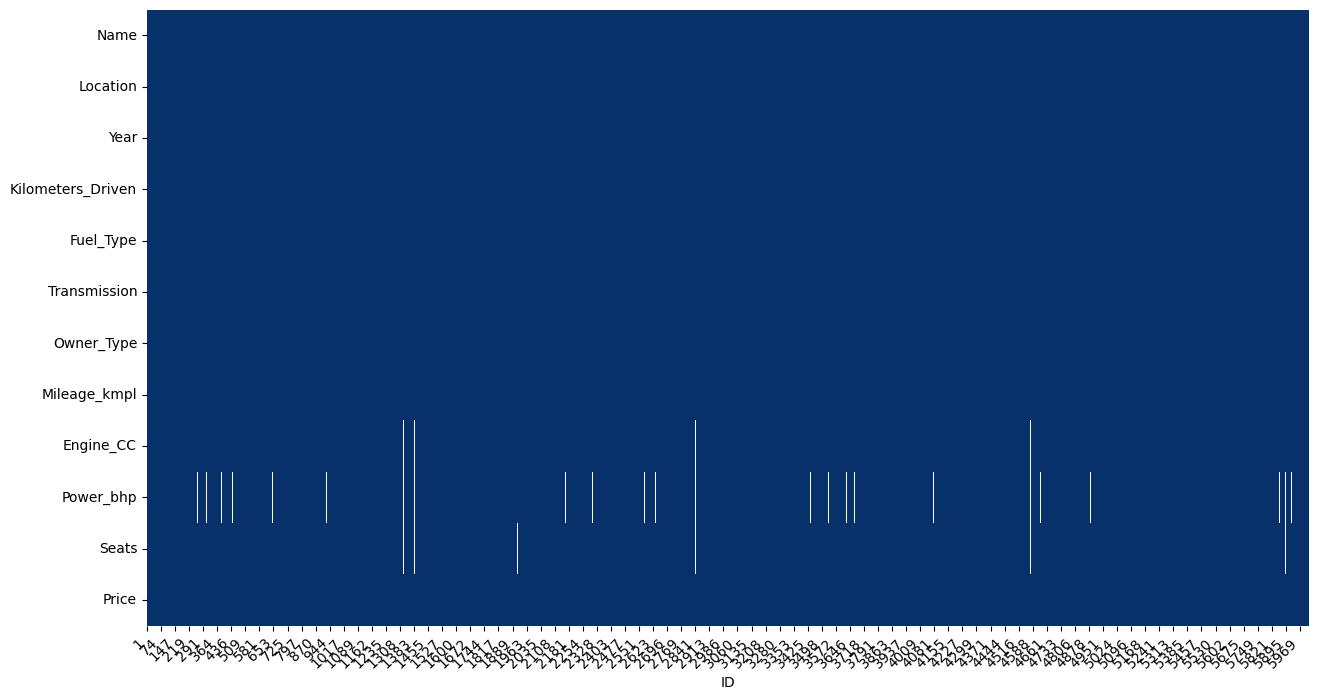

In [32]:
plot_missing_value(df)

In [33]:
df.drop(columns=['Name'], inplace=True)

# Dataset Splitting 

In [34]:
X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, X_test.shape, X_train.shape, y_train.shape

((4762, 10), (1191, 10), (4762, 10), (4762,))

# Training

In [35]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [36]:
X_train.head(3)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats
ID,,,,,,,,,,
4380,Coimbatore,2016,60913,Petrol,Manual,First,20.73,1373.0,91.1,5.0
2676,Kochi,2017,40459,Diesel,Manual,First,19.67,1582.0,126.2,5.0
647,Jaipur,2004,200000,Petrol,Manual,First,0.00,1086.0,NaN,5.0


In [37]:
X_train.columns

Index(['Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission',
       'Owner_Type', 'Mileage_kmpl', 'Engine_CC', 'Power_bhp', 'Seats'],
      dtype='object')

In [38]:
X_train.Seats.value_counts()

5.0     3946
7.0      545
8.0      111
4.0       74
6.0       28
2.0       15
10.0       4
9.0        3
Name: Seats, dtype: int64

In [39]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning) # untuk menghilangkan warning

In [40]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Year', 'Kilometers_Driven', 'Mileage_kmpl', 'Engine_CC', 'Power_bhp', 'Power_bhp', 'Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'])
])

# Pipeline
svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', SVR(max_iter=500))
])

# Parameter Tunning
model = GridSearchCV(svc_pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=0)
model.fit(X_train, y_train)

# Evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


{'algo__C': 10.0, 'algo__gamma': 0.001}
0.4138545188142674 0.08162903787317 0.04433514737224509


# Scaling can help SVM and KNN

In [41]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ['Year', 'Kilometers_Driven', 'Mileage_kmpl', 'Engine_CC', 'Power_bhp', 'Power_bhp', 'Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'])
])

# Pipeline
svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', SVR(max_iter=500))
])

# Parameter Tunning
model = GridSearchCV(svc_pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

# Evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-

{'algo__C': 10.0, 'algo__gamma': 0.1}
0.8689513671975948 0.8297763059361035 0.8324323820889034


# Feature Engineering: Polynomial Features

In [42]:
from luwiji.svm import demo

In [43]:
demo.poly_features()

interactive(children=(ToggleButtons(description='degree', options=(1, 2, 3), value=1), Checkbox(value=False, d…

In [44]:
gsp.svm_poly_params

{'prep__numeric__poly__degree': [1, 2, 3],
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [45]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, scaling='standard'), ['Year', 'Kilometers_Driven', 'Mileage_kmpl', 'Engine_CC', 'Power_bhp', 'Power_bhp', 'Seats']), # poly kalau bisa hanya dari angka 1 - 3
    ('categoric', cat_pipe(encoder='onehot'), ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'])
])

# Pipeline
svc_pipeline = Pipeline([
    ('prep', preprocessor), # ganti prep agar sesuai dengan parameter dari jcopml
    ('algo', SVR(max_iter=500))
])

# Parameter Tunning
model = GridSearchCV(svc_pipeline, gsp.svm_poly_params, cv=3, n_jobs=-1, verbose=1) # gunakan gsp.svm_poly_params
model.fit(X_train, y_train)

# Evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 294 candidates, totalling 882 fits


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-

{'algo__C': 10.0, 'algo__gamma': 0.1, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.8689513671975921 0.8297763059361033 0.8324323820888985
